# Activity estimation

## 0. Initial settings


__Comments guide__

[-]: Nothing out of ordinary

[B]: Assumed Background radiation

[U or blank]: Not localized 

In [1]:
import sys, os
from dateutil import parser
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import warnings
warnings.simplefilter(action='ignore')

# Setting directory
mypath_Cu = '/home/oline/Documents/Berkeley/lbl/room131/Monitor/Cu_rapports/Fits_repports/'

# Loading efficiency calibration
C05 = np.load('C05.npy')
C10 = np.load('C10.npy')
C15 = np.load('C15.npy')
C18 = np.load('C18.npy')
C22 = np.load('C22.npy')
C30 = np.load('C30.npy')
C40 = np.load('C40.npy')
C50 = np.load('C50.npy')
C60 = np.load('C60.npy')


Spec_Cu_1_10cm = np.load('Spec_Cu_1_10cm.npy')
Spec_Cu_1_50cm = np.load('Spec_Cu_1_50cm.npy')
Spec_Cu_2_10cm = np.load('Spec_Cu_2_10cm.npy')
Spec_Cu_2_50cm = np.load('Spec_Cu_2_50cm.npy')
Spec_Cu_3_10cm = np.load('Spec_Cu_3_10cm.npy')
Spec_Cu_3_50cm = np.load('Spec_Cu_3_50cm.npy')


In [2]:
"""
Read all information in directory
"""

def read_Fits_Rapport(path):
    live_time, date_spec, sample, distance = [], [], [], []
    fitsE, fitsN,  fitsN_unc = [], [], []
    
    for filename in os.listdir(path):
        with open(path + filename, 'r') as infile:
            lines = infile.readlines()
            fitz_energy, fitz_peak_area, fitz_peak_area_unc = get_Fitz_information(lines[33:])
            for j in range(len(fitz_energy)):
                fitsE.append(fitz_energy[j])
                fitsN.append(fitz_peak_area[j])
                fitsN_unc.append(fitz_peak_area_unc[j]/100)                      # Relative error 
                date_time = lines[20].split()[1] + ' '+ lines[20].split()[2]
                live_time.append(np.float(lines[21].split()[-1]))
                date_spec.append(str(parser.parse(date_time)))
                sample.append(filename[11:15])
                distance.append(filename[16:18])

    df = pd.DataFrame({'sample_ID': sample, 'distance [cm]': distance , 'fits_energy': fitsE, 'Peak_area': fitsN, 'Peak_area_unc': fitsN_unc, 'live_time [s]': live_time, 'date_time': date_spec })

    return df


def get_Fitz_information(lines):
    """ Called in the read_files function to obtain energy and peak area
    """
    energy, peak_area, peak_area_unc = [], [], []
    
    for line in lines:
        try:
            energy.append(float(line.split()[0]))
            peak_area.append(float(line.split()[5]))
            peak_area_unc.append(float(line.split()[6]))
        except ValueError:
            pass
        except IndexError:
            pass
        
    return energy, peak_area, peak_area_unc

In [3]:
"""
Prepare pandas dataframe for analysis
"""

def make_empty_str(title, df, length):
    df[title] = [''] * length
    return df

def make_empty_float(title, df, length):
    df[title] = np.array([np.NaN] * length)
    return df

def expand_frame(df):
    df = make_empty_str('Isotope', df, len(df))
    df = make_empty_str('Com', df, len(df))
    df = make_empty_str('Isotope Decaytime', df, len(df))
    df = make_empty_float('NucDat Energy [kEv]', df, len(df))
    df = make_empty_float('NucDat Energy unc [kEv]', df, len(df))
    df = make_empty_float('NucDat Intensity [%]', df, len(df))
    df = make_empty_float('NucDat Intensity unc [%]', df, len(df))
    return df

def information(df, Index, Isotope, Comment, Energy, Energy_unc, Intensity, Intensity_unc):
    df['Isotope'][Index] = Isotope
    df['Com'][Index] = Comment
    df['NucDat Energy [kEv]'][Index] =  Energy
    df['NucDat Energy unc [kEv]'][Index] =  Energy_unc
    df['NucDat Intensity [%]'][Index] = Intensity
    df['NucDat Intensity unc [%]'][Index] = Intensity_unc
    return df

def check_if_previously_identified(df1,df2):
    df_1 = df1.copy()
    df_2 = df2.copy()
    for i in range(len(df_1)):
        for j in range(len(df_2)):
            if abs(df_1['fits_energy'][i] - df_2['fits_energy'][j]) < 0.21:
                df_2['Isotope'][j] = df_1['Isotope'][i]
                df_2['Com'][j] = df_1['Com'][i]
                df_2['NucDat Energy [kEv]'][j] = df_1['NucDat Energy [kEv]'][i]
                df_2['NucDat Energy unc [kEv]'][j] = df_1['NucDat Energy unc [kEv]'][i]
                df_2['NucDat Intensity [%]'][j] = df_1['NucDat Intensity [%]'][i]
                df_2['NucDat Intensity unc [%]'][j] = df_1['NucDat Intensity unc [%]'][i]
    return df_2

def reorganize_columns(df_):
    df = df_.copy()
    df = df[['index',
             'sample_ID',
             'distance [cm]',
             'Isotope',
             'Com',
             'fits_energy',
             'NucDat Energy [kEv]',
             'NucDat Energy unc [kEv]',
             'NucDat Intensity [%]',
             'NucDat Intensity unc [%]',
             'Peak_area',
             'Peak_area_unc',
             'live_time [s]',
             'date_time',
             'Isotope Decaytime']]
    return df

## 1.0 CU

In [4]:
"""
Prepering Cu Database 
"""

Cu = read_Fits_Rapport(mypath_Cu)

Cu_1 = Cu[Cu['sample_ID'] == 'Cu-1']
Cu_2 = Cu[Cu['sample_ID'] == 'Cu-2']
Cu_3 = Cu[Cu['sample_ID'] == 'Cu-3']

Cu_1_50 = Cu_1[Cu_1['distance [cm]'] == '50'].reset_index()
Cu_1_10 = Cu_1[Cu_1['distance [cm]'] == '10'].reset_index()

Cu_2_50 = Cu_2[Cu_2['distance [cm]'] == '50'].reset_index()
Cu_2_10 = Cu_2[Cu_2['distance [cm]'] == '10'].reset_index()

Cu_3_50 = Cu_3[Cu_3['distance [cm]'] == '50'].reset_index()
Cu_3_10 = Cu_3[Cu_3['distance [cm]'] == '10'].reset_index()

Cu_1_50 = expand_frame(Cu_1_50)
Cu_1_10 = expand_frame(Cu_1_10)

Cu_2_50 = expand_frame(Cu_2_50)
Cu_2_10 = expand_frame(Cu_2_10)

Cu_3_50 = expand_frame(Cu_3_50)
Cu_3_10 = expand_frame(Cu_3_10)

# Cu 1, 50 cm

In [5]:
Cu_1_50  = information(Cu_1_50, 0,'62Zn',  '-', 40.84, 13, 25.5, np.NaN)
Cu_1_50  = information(Cu_1_50, 1,'61Cu/61Co',  '-',  '','','','')
Cu_1_50  = information(Cu_1_50, 2,'Background', '','','','','')
Cu_1_50  = information(Cu_1_50, 3,'Background, 74.8',  '', '','','','')
Cu_1_50  = information(Cu_1_50, 4,'Background',  '84.6. 56Cr, but E=26 gamma not found at I = 44.6, T_half = 5.94 min',  '','','','')
Cu_1_50  = information(Cu_1_50, 5,'Background, 87.2',  '',  '','','','')
Cu_1_50  = information(Cu_1_50, 6,'62Zn', '63Zn with E = 244.3, I = 0.09 % T_half = 28.47m', 243.39,'','','')
Cu_1_50  = information(Cu_1_50, 7,'62Zn', '-', 246.96, 5, 1.90, 10)
Cu_1_50  = information(Cu_1_50, 8,'62Zn', '-',  260.43, 7, 1.35, 8)
Cu_1_50  = information(Cu_1_50, 9, '61Cu', '-', 282.956, 2, 12.2, 3)
Cu_1_50  = information(Cu_1_50, 10, '61Cu', '-', 373.050, 5, 2.15, 5)
Cu_1_50  = information(Cu_1_50, 11, '62Zn','-', 394.03,6,2.236,10)
Cu_1_50  = information(Cu_1_50, 12, '62Zn', '11/12 wrong', 507.60, 10, 14.8,8)
Cu_1_50  = information(Cu_1_50, 13, 'Annihilation','-','','','','')
Cu_1_50  = information(Cu_1_50, 14, '?','Can be 63Zn, but I = ','','','','')
Cu_1_50  = information(Cu_1_50, 15, '62Zn','-', 548.35, 11, 15.3, 8)
Cu_1_50  = information(Cu_1_50, 16, '61Cu', '-', 588.605, 9, 1.168, 21)
Cu_1_50  = information(Cu_1_50, 17, '62Zn', '-', 596.56, 13, 26.0, np.NaN)
Cu_1_50  = information(Cu_1_50, 18, '61Cu', 'Other possibilities in 62Zn and 56Co, but I <0.04', 656.008, 4, 10.77, 18)
Cu_1_50  = information(Cu_1_50, 19, '62Zn/63Zn/B', '','','','','')
Cu_1_50  = information(Cu_1_50, 20, '61Co/61Cu', 'same problem as above','','','','')
Cu_1_50  = information(Cu_1_50, 21, 'B/63Zn','Likely, but is at 963.9 and is quite low','','','','')
Cu_1_50  = information(Cu_1_50, 22, '61Cu', '','','','','')
Cu_1_50  = information(Cu_1_50, 23, '61Cu','62Zn is possible, but I = 0.0039', 1185.234, 15,3.75, 7)
Cu_1_50  = information(Cu_1_50, 24, '64Cu', 'It is 1.2 off?', 1345.84, 4, 0.473, 10)
Cu_1_50  = information(Cu_1_50, 25, '63Zn', 'FAR OFF', 1412.08,5,0.75, 3)
Cu_1_50  = information(Cu_1_50, 26, '62Zn', 'I to low to be taken seriously', 1485.1,5,0.0005,3)

for i in range(len(Cu_1_50['Isotope Decaytime'])):
    if Cu_1_50['Isotope'][i] == '62Zn':
        Cu_1_50['Isotope Decaytime'][i] = '9.186  h 13'

In [6]:
Cu_1_50 = reorganize_columns(Cu_1_50)
Cu_1_50

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,67,Cu-1,50,62Zn,-,40.7,40.84,13,25.5,NaN,26622.0,0.038,301.0,2019-02-26 05:49:00,9.186 h 13
1,68,Cu-1,50,61Cu/61Co,-,67.3,,,,,21144.0,0.023,301.0,2019-02-26 05:49:00,
2,69,Cu-1,50,Background,,72.7,,,,,8909.0,0.070,301.0,2019-02-26 05:49:00,
3,70,Cu-1,50,"Background, 74.8",,74.9,,,,,15681.0,0.041,301.0,2019-02-26 05:49:00,
4,71,Cu-1,50,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.7,,,,,6625.0,0.073,301.0,2019-02-26 05:49:00,
5,72,Cu-1,50,"Background, 87.2",,87.3,,,,,1834.0,0.255,301.0,2019-02-26 05:49:00,
6,73,Cu-1,50,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,1933.0,0.127,301.0,2019-02-26 05:49:00,9.186 h 13
7,74,Cu-1,50,62Zn,-,247.2,246.96,5,1.9,10,1433.0,0.173,301.0,2019-02-26 05:49:00,9.186 h 13
8,75,Cu-1,50,62Zn,-,260.8,260.43,7,1.35,8,833.0,0.303,301.0,2019-02-26 05:49:00,9.186 h 13
9,76,Cu-1,50,61Cu,-,283.2,282.956,2,12.2,3,7045.0,0.045,301.0,2019-02-26 05:49:00,


# Cu 1, 10 cm

In [7]:
Cu_1_10 = check_if_previously_identified(Cu_1_50, Cu_1_10)



In [8]:
Cu_1_10 = reorganize_columns(Cu_1_10)

Cu_1_10  = information(Cu_1_10, 8, '62Zn', 'Migh be background contamination', 349.60,13,0.45,3)

Cu_1_10  = information(Cu_1_10, 10, '62Zn', '', 507.6,10,14.8,8)
Cu_1_10  = information(Cu_1_10, 17, '62Zn', '', 637.41,7,0.255,16)
Cu_1_10  = information(Cu_1_10, 18, '58Co', '', 810.775,9,99,np.NaN)

Cu_1_10

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,114,Cu-1,10,62Zn,-,40.7,40.84,13,25.5,NaN,44669.0,0.012,502.0,2019-02-27 18:37:00,
1,115,Cu-1,10,Background,,72.7,,,,,5899.0,0.083,502.0,2019-02-27 18:37:00,
2,116,Cu-1,10,"Background, 74.8",,74.9,,,,,10504.0,0.048,502.0,2019-02-27 18:37:00,
3,117,Cu-1,10,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.7,,,,,4969.0,0.055,502.0,2019-02-27 18:37:00,
4,118,Cu-1,10,"Background, 87.2",,87.3,,,,,1388.0,0.177,502.0,2019-02-27 18:37:00,
5,119,Cu-1,10,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,3337.0,0.082,502.0,2019-02-27 18:37:00,
6,120,Cu-1,10,62Zn,-,247.3,246.96,5,1.9,10,2570.0,0.103,502.0,2019-02-27 18:37:00,
7,121,Cu-1,10,62Zn,-,260.8,260.43,7,1.35,8,1468.0,0.174,502.0,2019-02-27 18:37:00,
8,122,Cu-1,10,62Zn,Migh be background contamination,349.9,349.6,13,0.45,3,424.0,0.523,502.0,2019-02-27 18:37:00,
9,123,Cu-1,10,62Zn,-,394.5,394.03,6,2.236,10,1843.0,0.098,502.0,2019-02-27 18:37:00,


# Cu 2, 10 cm

In [9]:
Cu_2_10 = check_if_previously_identified(Cu_1_10, Cu_2_10)

In [10]:
Cu_2_10 = reorganize_columns(Cu_2_10)

Cu_2_10

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,0,Cu-2,10,62Zn,-,40.7,40.84,13,25.5,NaN,44210.0,0.011,658.0,2019-02-27 18:48:00,
1,1,Cu-2,10,Background,,72.7,,,,,6805.0,0.045,658.0,2019-02-27 18:48:00,
2,2,Cu-2,10,"Background, 74.8",,74.9,,,,,12089.0,0.027,658.0,2019-02-27 18:48:00,
3,3,Cu-2,10,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.7,,,,,5128.0,0.056,658.0,2019-02-27 18:48:00,
4,4,Cu-2,10,"Background, 87.2",,87.3,,,,,1293.0,0.199,658.0,2019-02-27 18:48:00,
5,5,Cu-2,10,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,2932.0,0.086,658.0,2019-02-27 18:48:00,
6,6,Cu-2,10,62Zn,-,247.3,246.96,5,1.9,10,2128.0,0.121,658.0,2019-02-27 18:48:00,
7,7,Cu-2,10,62Zn,-,260.8,260.43,7,1.35,8,1625.0,0.164,658.0,2019-02-27 18:48:00,
8,8,Cu-2,10,62Zn,Migh be background contamination,349.9,349.6,13,0.45,3,437.0,0.518,658.0,2019-02-27 18:48:00,
9,9,Cu-2,10,62Zn,-,394.5,394.03,6,2.236,10,1969.0,0.099,658.0,2019-02-27 18:48:00,


# Cu 2, 50 cm

In [11]:
Cu_2_50 = check_if_previously_identified(Cu_1_50, Cu_2_50)
Cu_2_50 = check_if_previously_identified(Cu_1_10, Cu_2_50)


Cu_2_50  = information(Cu_2_50, 11, '63Zn', 'No other possibilities', 449.93, 5, 0.236, 16)
Cu_2_50  = information(Cu_2_50, 20, '', 'No matches','','','','')


Cu_2_50 = reorganize_columns(Cu_2_50)


Cu_2_50

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,41,Cu-2,50,62Zn,-,40.7,40.84,13,25.5,NaN,18685.0,0.022,301.0,2019-02-26 05:56:00,
1,42,Cu-2,50,61Cu/61Co,-,67.3,,,,,4520.0,0.065,301.0,2019-02-26 05:56:00,
2,43,Cu-2,50,Background,,72.7,,,,,7901.0,0.072,301.0,2019-02-26 05:56:00,
3,44,Cu-2,50,"Background, 74.8",,74.9,,,,,14310.0,0.041,301.0,2019-02-26 05:56:00,
4,45,Cu-2,50,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.7,,,,,6266.0,0.046,301.0,2019-02-26 05:56:00,
5,46,Cu-2,50,"Background, 87.2",,87.3,,,,,1848.0,0.137,301.0,2019-02-26 05:56:00,
6,47,Cu-2,50,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,1256.0,0.186,301.0,2019-02-26 05:56:00,
7,48,Cu-2,50,62Zn,-,247.4,246.96,5,1.9,10,949.0,0.243,301.0,2019-02-26 05:56:00,
8,49,Cu-2,50,62Zn,-,260.7,260.43,7,1.35,8,688.0,0.353,301.0,2019-02-26 05:56:00,
9,50,Cu-2,50,61Cu,-,283.2,282.956,2,12.2,3,679.0,0.371,301.0,2019-02-26 05:56:00,


# Cu 3, 10

In [12]:
Cu_3_10 = check_if_previously_identified(Cu_1_10, Cu_3_10)
Cu_2_50  = information(Cu_2_50, 16, '63Zn~', 'Belived to be a misFIT', 685.6, 6, 0.0041, 16)

Cu_3_10 = reorganize_columns(Cu_3_10)
Cu_3_10

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,94,Cu-3,10,62Zn,-,40.7,40.84,13,25.5,NaN,31806.0,0.015,1004.0,2019-02-27 19:00:00,
1,95,Cu-3,10,Background,,72.7,,,,,6495.0,0.044,1004.0,2019-02-27 19:00:00,
2,96,Cu-3,10,"Background, 74.8",,74.9,,,,,11758.0,0.027,1004.0,2019-02-27 19:00:00,
3,97,Cu-3,10,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.8,,,,,4749.0,0.058,1004.0,2019-02-27 19:00:00,
4,98,Cu-3,10,"Background, 87.2",,87.4,,,,,1361.0,0.179,1004.0,2019-02-27 19:00:00,
5,99,Cu-3,10,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,2371.0,0.109,1004.0,2019-02-27 19:00:00,
6,100,Cu-3,10,62Zn,-,247.3,246.96,5,1.9,10,1644.0,0.152,1004.0,2019-02-27 19:00:00,
7,101,Cu-3,10,62Zn,-,260.8,260.43,7,1.35,8,974.0,0.249,1004.0,2019-02-27 19:00:00,
8,102,Cu-3,10,62Zn,Migh be background contamination,350.0,349.6,13,0.45,3,386.0,0.568,1004.0,2019-02-27 19:00:00,
9,103,Cu-3,10,62Zn,-,394.5,394.03,6,2.236,10,1376.0,0.128,1004.0,2019-02-27 19:00:00,


# Cu 3, 50

In [13]:
Cu_3_50 = check_if_previously_identified(Cu_1_50, Cu_3_50)

Cu_3_50 = reorganize_columns(Cu_3_50)

In [14]:
Cu_3_50  = information(Cu_3_50, 20,'-',  'Cant find any good match','','','','')

Cu_3_50 = information(Cu_3_50, 1, '61Co',  '61Cu, but non strong I gammas present. Also no less strong gamma of 61Co present, which is a bit wierd', 67.412, 3, 85, np.NaN)
Cu_3_50 = information(Cu_3_50, 2, 'Background','','','','','')
Cu_3_50 = information(Cu_3_50, 7, '62zN','-', 394.03, 6, 2.236, 10)

Cu_3_50

,index,sample_ID,distance [cm],Isotope,Com,fits_energy,NucDat Energy [kEv],NucDat Energy unc [kEv],NucDat Intensity [%],NucDat Intensity unc [%],Peak_area,Peak_area_unc,live_time [s],date_time,Isotope Decaytime
0,20,Cu-3,50,62Zn,-,40.7,40.84,13,25.5,NaN,9236.0,0.038,320.0,2019-02-26 06:03:00,
1,21,Cu-3,50,61Co,"61Cu, but non strong I gammas present. Also no...",67.2,67.412,3,85,NaN,724.0,0.375,320.0,2019-02-26 06:03:00,
2,22,Cu-3,50,Background,,72.7,,,,,8274.0,0.071,320.0,2019-02-26 06:03:00,
3,23,Cu-3,50,"Background, 74.8",,74.9,,,,,15163.0,0.040,320.0,2019-02-26 06:03:00,
4,24,Cu-3,50,Background,"84.6. 56Cr, but E=26 gamma not found at I = 44...",84.7,,,,,6531.0,0.045,320.0,2019-02-26 06:03:00,
5,25,Cu-3,50,"Background, 87.2",,87.3,,,,,1916.0,0.144,320.0,2019-02-26 06:03:00,
6,26,Cu-3,50,62Zn,"63Zn with E = 244.3, I = 0.09 % T_half = 28.47m",243.7,243.39,,,,668.0,0.375,320.0,2019-02-26 06:03:00,
7,27,Cu-3,50,62zN,-,394.4,394.03,6,2.236,10,440.0,0.408,320.0,2019-02-26 06:03:00,
8,28,Cu-3,50,,,450.5,NaN,NaN,NaN,NaN,410.0,0.414,320.0,2019-02-26 06:03:00,
9,29,Cu-3,50,62Zn,11/12 wrong,508.0,507.6,10,14.8,8,4460.0,0.072,320.0,2019-02-26 06:03:00,


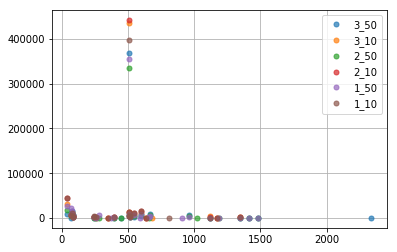

In [15]:
#fig1 = plt.figure(figsize = (20,15))
plt.plot(Cu_3_50['fits_energy'], Cu_3_50['Peak_area'], 'o', markersize = 5, alpha = 0.7)
plt.plot(Cu_3_10['fits_energy'], Cu_3_10['Peak_area'], 'o', markersize = 5, alpha = 0.7)

plt.plot(Cu_2_50['fits_energy'], Cu_2_50['Peak_area'], 'o', markersize = 5, alpha = 0.7)
plt.plot(Cu_2_10['fits_energy'], Cu_2_10['Peak_area'], 'o', markersize = 5, alpha = 0.7)

plt.plot(Cu_1_50['fits_energy'], Cu_1_50['Peak_area'], 'o', markersize = 5, alpha = 0.7)
plt.plot(Cu_1_10['fits_energy'], Cu_1_10['Peak_area'], 'o', markersize = 5, alpha = 0.7)

plt.legend(['3_50','3_10', '2_50','2_10','1_50','1_10'])
plt.grid('on')
#plt.xticks(size = 50)
#plt.xlim([1095,1105])
#plt.ylim([0,10000])

In [16]:
def get_y_values(data, match):
    length = len(data.values)
    y_vals = np.zeros(length)
    for i in range(length):
        x_val = data.values[i]
        index = np.argmin(np.abs(x_val - match[0]))
        y_vals[i] = match[1][index]
    return y_vals
    


In [17]:
# Isotopes Cu_1_10
sub_62Zn = Cu_1_10[Cu_1_10['Isotope'] == '62Zn']
sub_62Zn_y = get_y_values(sub_62Zn['fits_energy'], Spec_Cu_1_10cm)
sub_62Zn_x = sub_62Zn['fits_energy']

sub_58Co = Cu_1_10[Cu_1_10['Isotope'] == '58Co']
sub_58Co_y = get_y_values(sub_58Co['fits_energy'], Spec_Cu_1_10cm)
sub_58Co_x = sub_58Co['fits_energy']

sub_64Cu = Cu_1_10[Cu_1_10['Isotope'] == '64Cu']
sub_64Cu_y = get_y_values(sub_64Cu['fits_energy'], Spec_Cu_1_10cm)
sub_64Cu_x = sub_64Cu['fits_energy']

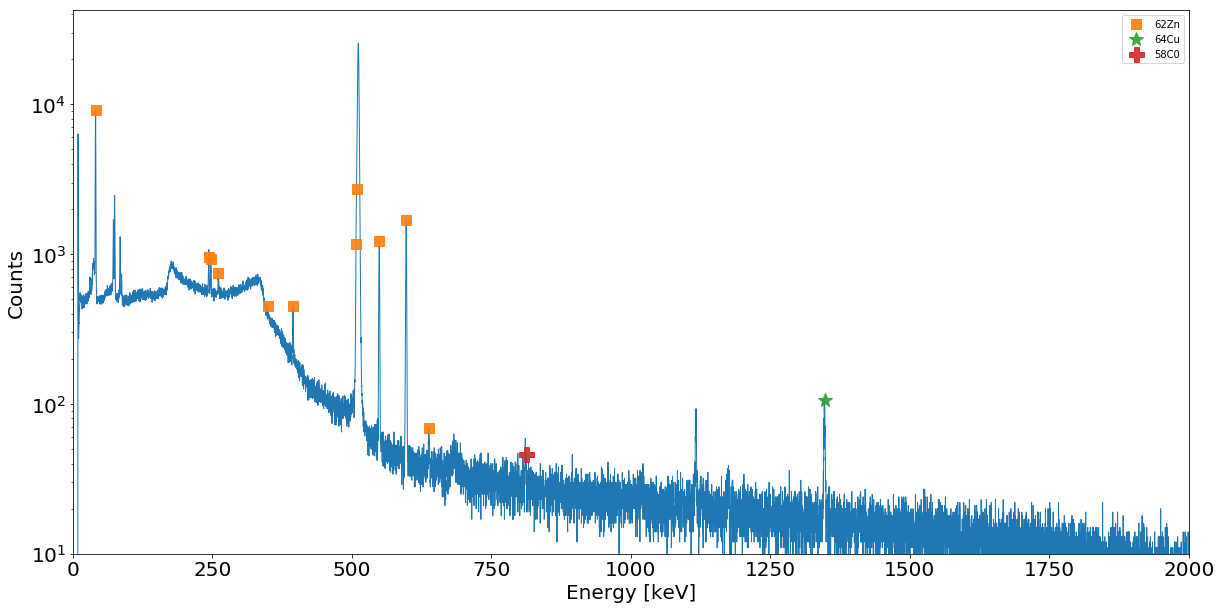

In [18]:
plt.figure(figsize = (20,10))
plt.semilogy(Spec_Cu_1_10cm[0],Spec_Cu_1_10cm[1], linewidth = 1)
plt.semilogy(sub_62Zn_x, sub_62Zn_y, 's', markersize = 10, alpha = 0.9, label = '62Zn')
plt.semilogy(sub_64Cu_x, sub_64Cu_y, '*', markersize = 15, alpha = 0.9, label = '64Cu')
plt.semilogy(sub_58Co_x, sub_58Co_y, 'P', markersize = 15, alpha = 0.9, label = '58C0')
plt.ylim(ymin=10)
plt.xlim([0,2000])
plt.xlabel('Energy [keV]', fontsize = 20)
plt.ylabel('Counts',  fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()

# Activity

In [19]:
Cu_decay_constant = 243.93*24*60

def activity(Nc, decay_const, I_gamma, eff_gamma, t_live):
    return Nc*decay_const/(I_gamma*eff_gamma*(1-e**(-decay_const*t_live)))

In [20]:
def eff_curve(E,*B):
    E = E.values
    B = B[0]
    Efficiency = np.zeros(len(E))
    for i in range(len(E)):
        Efficiency[i] =  B[0]*np.exp(-B[1]*E[i]**B[2])*(1-np.exp(-B[3]*E[i]**B[4]))
    return Efficiency

In [21]:
sub_62Zn['efficiancy'] = eff_curve(sub_62Zn['NucDat Energy [kEv]'],C10)

In [26]:
print(Spec_Cu_1_10cm[0][-1])

3078.1
